In [3]:
# 1 time vs number of clusters
# 2 time vs regularization
# 3 quality vs regularization
# 4 quality kmeans vs random sampling
# 5 time vs sparsity level
# 6 quality vs sparsity level

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ot

# I don't know how else to import functions from src
import sys, os
sys.path.insert(0,
    os.path.dirname((os.path.abspath("."))))
from src.sinkhorn import sinkhorn_knopp, sinkhorn_stabilized
del sys.path[0]

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import cv2

from scipy.optimize import curve_fit

In [5]:
def initialize_random_centroids(flatten_image, n_clusters, max_iter=1000):
    clusters = set()
    i = 0 
    while len(clusters) != n_clusters:
        num_of_points = n_clusters - len(clusters)
        new_points = np.random.choice(len(flatten_image), num_of_points)
        clusters = clusters.union({tuple(el) for el in flatten_image[new_points]})
        i += 1 
        if i > max_iter:
            raise RuntimeError("Couldn't initiate centroids")
    return np.array(list(clusters))


def color_clustering(im, n_clust=30, mode="kmeans"):
    # https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/
    def _centroid_histogram(clt):
        numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
        (hist, _) = np.histogram(clt.labels_, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        return hist
    
    im_flatten = im.reshape((-1, 3))
    if mode == "kmeans":
        clt = KMeans(n_clusters=n_clust)
    elif mode == "random":
        random_centroids = initialize_random_centroids(im_flatten, n_clust)
        clt = KMeans(n_clusters=n_clust, max_iter=1, init=random_centroids, n_init=1)
       
    clt.fit(im_flatten)
    hist = _centroid_histogram(clt)  
    colors = clt.cluster_centers_
    return hist, colors, clt.labels_
        


def transport(target_image, sourse_colors, target_colors, target_clusters, transportation_plan):
    """
    Transforms target image, transporting sourse color from sourse clusters according to the transportation plan.
    """
    col_normalized = transportation_plan.T / np.sum(transportation_plan, 0)[:, None]
    col_normalized[~ np.isfinite(col_normalized)] = 0
    im_transp = ((col_normalized @ sourse_colors)[target_clusters, :]
                 + target_image.reshape((-1, 3))
                 - target_colors[target_clusters, :])
    im_transp = im_transp.reshape(target_image.shape)

    return im_transp

def preprocessing(image1, image2, n_clust=30, mode="kmeans"):
    """
    Takes images as an input, returns supply + coordinates, demand + coordinates and cost matrix.
    """
    hist1, colors1, _ = color_clustering(image1, n_clust, mode=mode)
    hist2, colors2, clusters2 = color_clustering(image2, n_clust, mode=mode)
    cost = np.zeros((len(hist1), len(hist2)))
    for i in range(len(hist1)):
        for j in range(len(hist2)):
            cost[i, j] = np.linalg.norm(colors1[i] - colors2[j])
    return hist1, colors1, hist2, colors2, clusters2, cost


def do_work(a, b, cost_matrix, algorithm, reg=0.01, make_sparse=False, strategy=None, min_nnz=None):
    """
    This thing is expected to be tested - that's where our implementation differs from default.
    """
    if algorithm == "default":
         method = lambda x,y,z: ot.sinkhorn(x,y,z,reg=reg)
    elif algorithm == "default_stabilized":
        method = lambda x,y,z: ot.bregman.sinkhorn_stabilized(x,y,z,reg=reg)
    elif algorithm == "kuznedelev_vanilla":
        if strategy:
            method = lambda x,y,z: sinkhorn_knopp(a=x, b=y, C=z, reg=reg, make_sparse=make_sparse, sparsification_strategy=strategy, min_nnz=min_nnz)
        else:
            method = lambda x,y,z: sinkhorn_knopp(a=x, b=y, C=z, reg=reg, make_sparse=make_sparse)
    elif algorithm == "kuznedelev_stabilized":
        method = lambda x,y,z: sinkhorn_stabilized(a=x, b=y, C=z, reg=reg)
    else:
        raise NotImplementedError(f"We don't have an algorithm {algorithm} implemented.")
    transportation_plan = method(a, b, cost_matrix)
    return transportation_plan


There goes a bunch of cells, each designed to test some aspect of our implementation compared to the default one and plot this aspect.

In [72]:
# 1
def comparator_by_number_of_clusters(image1, image2):
    """
    Performs color transfering with different cluster numbers. 
    Measures time spent on color transferring.
    """
    n_clusters = [10, 30, 100, 300, 500, 1000, 2000, 3500]
    default_implementation, kuznedelev_implementation_vanilla = [], []
    for n_clust in n_clusters:
        hist1, colors1, hist2, colors2, clusters2, cost = preprocessing(image1, image2, n_clust=n_clust, mode="random")
        
        time = %timeit -o plan = do_work(hist1, hist2, cost, "default")
        default_implementation.append(time.average)

        time = %timeit -o plan = do_work(hist1, hist2, cost, "kuznedelev_vanilla")
        kuznedelev_implementation_vanilla.append(time.average)
    df = pd.DataFrame({"n_clusters":n_clusters, "from_POT":default_implementation, "custom":kuznedelev_implementation_vanilla})
    df.to_csv("csv/1_performance_on_different_number_of_clusters.csv", index=False)

def plot_comparator_by_number_of_clusters():
    def fit(n, c):
        return c*(n**2) * (np.log(n)/np.log(3))
    
    df = pd.read_csv("csv/1_performance_on_different_number_of_clusters.csv")
    
    opt_c_pot = curve_fit(fit, np.array(df.n_clusters), df.from_POT)
    opt_c_custom = curve_fit(fit, np.array(df.n_clusters), df.custom)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.semilogy(df.n_clusters, df.from_POT, marker="*", markersize=10, linestyle="--", label="from POT")
    plt.semilogy(df.n_clusters, df.custom, marker="*", markersize=10, linestyle="--", label="custom")
    plt.semilogy(df.n_clusters, fit(np.array(df.n_clusters), opt_c_pot[0]), label=f"$n^2log_3(n) fit$") # actually, for POt, but such label wouldn't make sence sine I don't plot fit for custom
#    Essentially, the same curve, so I decided not to plot it
#     plt.semilogy(df.n_clusters, fit(np.array(df.n_clusters), opt_c_custom[0]), label=f"$n^2log_3(n) fit for custom$")
    
    
    plt.legend()
    plt.xlabel("Sample size, pixels", size=20)
    plt.ylabel("Running time, seconds", size=20)
    plt.title("Running time dependence on the sample size", size=20)
    plt.savefig("png/performance_on_different_cluster_sizes.png")


In [95]:
# 2 & 3
def comparator_by_regularisation_term(image1, image2):
    regs = np.logspace(-3, 2, 6)
    
    default_implementation, default_implementation_stab, kuznedelev_implementation, kuznedelev_implementation_stab = [], [], [], []
    hist1, colors1, hist2, colors2, clusters2, cost = preprocessing(image1, image2, n_clust=3400, mode="random")
    quality_default, quality_default_stab, quality_kuznedelev, quality_kuznedelev_stab = [], [], [], []
    for i, reg in enumerate(regs):
        time = %timeit -o plan = do_work(hist1, hist2, cost, "default", reg=reg)
        default_implementation.append(time.average)
        transportation_plan_default = do_work(hist1, hist2, cost, "default", reg=reg)
        quality_default.append((cost*transportation_plan_default).sum())
                
        time = %timeit -o plan = do_work(hist1, hist2, cost, "default_stabilized", reg=reg)
        default_implementation_stab.append(time.average)
        transportation_plan_default_stab = do_work(hist1, hist2, cost, "default_stabilized", reg=reg)
        quality_default_stab.append((cost*transportation_plan_default_stab).sum())
        
        time = %timeit -o plan = do_work(hist1, hist2, cost, "kuznedelev_vanilla", reg=reg)
        kuznedelev_implementation.append(time.average)
        transportation_plan_kuznedelev = do_work(hist1, hist2, cost, "kuznedelev_vanilla", reg=reg)
        quality_kuznedelev.append((cost*transportation_plan_kuznedelev).sum())
        
        
        time = %timeit -o plan = do_work(hist1, hist2, cost, "kuznedelev_stabilized", reg=reg)
        kuznedelev_implementation_stab.append(time.average)
        transportation_plan_kuznedelev_stab = do_work(hist1, hist2, cost, "kuznedelev_stabilized", reg=reg)
        quality_kuznedelev_stab.append((cost*transportation_plan_kuznedelev_stab).sum())
    
    df_time = pd.DataFrame({"reg":regs, 
                            "from_POT":default_implementation,
                            "from_POT_stab":default_implementation_stab,
                            "custom":kuznedelev_implementation,
                            "custom_stab": kuznedelev_implementation_stab})
    df_time.to_csv("csv/2_running_time_comparison_between_implementations_with_different_regs.csv")
    
    df_qual = pd.DataFrame({"reg":regs, 
                            "from_POT":quality_default,
                            "from_POT_stab":quality_default_stab,
                            "custom":quality_kuznedelev,
                            "custom_stab": quality_kuznedelev_stab})
    df_qual.to_csv("csv/3_quality_comparison_between_implementations_with_different_regs.csv")
    
def plot_xxx_by_regularisation_term(xxx="quality"):
    if xxx == "quality":
        df = pd.read_csv("csv/3_quality_comparison_between_implementations_with_different_regs.csv")
        ylabel = "Transportation cost"
        title = "Transportation cost dependence on the regularization"
        filename = "png/Quality_comparison_between_implementations_with_different_regs.png"
    elif xxx == "time":
        df = pd.read_csv("csv/2_running_time_comparison_between_implementations_with_different_regs.csv")
        ylabel = "Running time, sec"
        title = "Running time dependence on the regularization"
        filename = "png/Running_time_comparison_between_implementations_with_different_regs.png"
        
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(df.reg, df.from_POT, marker="*", markersize=10, linestyle="--", label="from POT")
    ax.plot(df.reg, df.from_POT_stab, marker="*", markersize=10, linestyle="--", label="from POT stabilized")
    ax.plot(df.reg, df.custom, marker="*", markersize=10, linestyle="--", label="custom")
    ax.plot(df.reg, df.custom_stab, marker="*", markersize=10, linestyle="--", label="custom stabilized")    
   
        
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_xlabel("Regularization term", size=20)
    ax.set_ylabel(ylabel, size=20)
    ax.set_title(title, size=20)
    plt.legend()
    plt.savefig(filename)
    

In [36]:
# 4
def comparator_quality_by_sampling(image1, image2, reg=0.01):
    nn_clusters = (30, 50, 100, 200, 300)
    qualities_default = [[],[]]
    qualities_kuznedelev = [[], []]
    for n_clusters in nn_clusters:
        for i, mode in enumerate(("kmeans", "random")):
            hist1, _, hist2, _, _, cost = preprocessing(image1, image2, n_clust=n_clusters, mode=mode)
            transportation_plan_default = do_work(hist1, hist2, cost, "default", reg=reg)
            qualities_default[i].append((cost*transportation_plan_default).sum())
            
            transportation_plan_kuznedelev = do_work(hist1, hist2, cost, "kuznedelev_stabilized", reg=reg)
            qualities_kuznedelev[i].append((cost*transportation_plan_kuznedelev).sum())
    df = pd.DataFrame({"n_clusters":nn_clusters, "from_POT_k_means":qualities_default[0], "custom_kmeans":qualities_kuznedelev[0], "from_POT_random": qualities_default[1], "custom_random":qualities_kuznedelev[1]}) 
    df.to_csv("csv/4_quality_vs_sampling_procedure.csv", index=False)
    
def plot_quality_by_sampling():
    df = pd.read_csv("csv/4_quality_vs_sampling_procedure.csv")
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(df.n_clusters, df.from_POT_k_means, marker="*", markersize=10, linestyle="--", label="default kmeans")
    ax.plot(df.n_clusters, df.from_POT_random, marker="*", markersize=10, linestyle="--", label="default random")
    ax.plot(df.n_clusters, df.custom_kmeans, marker="*", markersize=10, linestyle="--", label="custom kmeans")
    ax.plot(df.n_clusters, df.custom_random, marker="*", markersize=10, linestyle="--", label="custom random")
    ax.set_xlabel("Number sample size", size=20)
    ax.set_ylabel("Transportation cost", size=20)
    ax.set_title('Transportation cost dependence on the sampling strategy', size=20)
    plt.legend()
    plt.savefig("png/Quality_vs_sampling_procedure.png")

In [44]:
# 5 & 6
def comparator_by_sparsity(image1, image2):
    max_elements = 2**np.arange(7, 11)
    sparse_time = []
    sparse_qualities = []
    sparse_nnz_frac = []
    hist1, colors1, hist2, colors2, clusters2, cost = preprocessing(image1, image2, n_clust=4048, mode="random")
    
    time = %timeit -o plan = do_work(hist1, hist2, cost, algorithm="kuznedelev_vanilla")
    plan = do_work(hist1, hist2, cost, algorithm="kuznedelev_vanilla", reg=1)
    
    dense_time = [time.average]*len(max_elements)
    dense_quality = [(plan*cost).sum()]*len(max_elements)
    fig, ax = plt.subplots(len(max_elements), 1, figsize=(20, 20*len(max_elements)))
    
    for i, max_element in enumerate(max_elements):
        time = %timeit -o plan = do_work(hist1, hist2, cost, reg=1, algorithm="kuznedelev_vanilla", make_sparse=True, strategy="keep_n_largest", min_nnz=max_element)
        plan = do_work(hist1, 
                       hist2, 
                       cost, 
                       reg=1, 
                       algorithm="kuznedelev_vanilla", 
                       make_sparse=True, 
                       strategy="keep_n_largest", 
                       min_nnz=max_element)
        print(max_element, plan.sum())
        plan_np = np.array(plan.todense())
        image = transport(image2, colors1, colors2, clusters2, plan_np)
        ax[i].imshow(image)
        sparse_time.append(time.average)


        sparse_quality = (plan_np*cost).sum()
        sparse_qualities.append(sparse_quality)
        sparsification_level = plan.nnz / (plan.shape[0] * plan.shape[1])
        ax[i].set_ylabel(f"fraction of nnz = " + str(round(sparsification_level, 2)), size=20)
        ax[i].get_xaxis().set_visible(False)
        sparse_nnz_frac.append(sparsification_level)
    plt.savefig("png/quality_vs_sparsification_images.png")
    df = pd.DataFrame({"sparse_nnz_frac":sparse_nnz_frac, "sparse_quality":sparse_qualities, "dense_quality":dense_quality})
#     df = pd.DataFrame({"sparse_nnz_frac":sparse_nnz_frac, "sparse_time":s parse_time, "sparse_quality":sparse_quality, "dense_time":dense_time, "dense_quality":dense_quality})
    df.to_csv("csv/6_quality_by_sparsification_level.csv", index=False)
    

def plot_xxx_by_sparsity(xxx="quality"):

    plt.figure(figsize=(10, 10))
    if xxx == "quality":
        df = pd.read_csv("csv/6_quality_by_sparsification_level.csv")
        plt.plot(df.sparse_nnz_frac, df.sparse_quality, marker="*", markersize=10, linestyle="--", label="sparse")
        plt.plot(df.sparse_nnz_frac, df.dense_quality, linestyle="--", label="dense")
        ylabel = "Transportation cost"
        title = "Transportation cost dependence on sparsification level"
    elif xxx == "time":
        df = pd.read_csv("csv/5_6_performance_by_sparsification_level.csv")
        plt.plot(df.sparse_nnz_frac[:-2], df.sparse_time[:-2], marker="*", markersize=10, linestyle="--", label="sparse")
        plt.plot(df.sparse_nnz_frac[:-2], df.dense_time[:-2], linestyle="--", label="dense")
        ylabel="time, sec"
        title = "Running time dependence on sparsification level"
    plt.xlabel("fraction of non-zeroes for sparse", size=20) 
    plt.ylabel(ylabel, size=20)
    plt.title(title, size=20)
    plt.legend()
    

In [38]:
def show_transfer_by_different_implementations(image1, image2, reg=0.01, n_clust=30):

    hist1, colors1, hist2, colors2, clusters2, cost = preprocessing(image1, image2, n_clust=n_clust)
    
    transportation_plan_default = do_work(hist1, hist2, cost, "default", reg)
    transportation_plan_kuznedelev = do_work(hist1, hist2, cost, "kuznedelev_vanilla", reg)
    
    transformed_by_default_implementation = transport(image2, colors1, colors2, clusters2, transportation_plan_default)
    transformed_by_kuznedelev_implementation = transport(image2, colors1, colors2, clusters2, transportation_plan_kuznedelev)
    
            
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    
    # Removing axes
    for i in range(2):
        for j in range(2):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)

    # Plotting
    
    ax[0, 0].imshow(image1)
    ax[0, 0].set_title("Sourse image")
    
    ax[0, 1].imshow(image2)
    ax[0, 1].set_title("Destination image")
    
    
    ax[1, 0].imshow(transformed_by_default_implementation)
    ax[1, 0].set_title("Transformed by default implementation")
    
    ax[1, 1].imshow(transformed_by_kuznedelev_implementation)
    ax[1, 1].set_title("Transformed by custom implementation")
    plt.savefig("png/Demonstration of transfer.png")
    


In [11]:
I1 = plt.imread('../images/ocean_daylight.png').astype(np.float64)[:, :, :3]
I2 = plt.imread('../images/ocean_sunset.png').astype(np.float64)[:, :, :3]

# Data collection

In [32]:
comparator_by_number_of_clusters(I1, I2)

10.3 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.6 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.9 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.9 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
220 ms ± 40.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
41.3 ms ± 7.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.47 times longer than the fastest. This could mean that an intermediate result is being cached.
114 ms ± 73.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
55.5 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
114 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
83.6 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
375 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
248 ms ± 8.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.59 s ± 203 ms per loop (mean ± std. dev. of

In [47]:
comparator_quality_by_sampling(I1, I2)

In [10]:
comparator_by_regularisation_term(I1, I2)

35.5 s ± 469 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8min 1s ± 13.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.2 s ± 616 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8min 32s ± 23.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.21 s ± 220 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8min 13s ± 30.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.18 s ± 533 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7min 53s ± 22.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
875 ms ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.9 s ± 79.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
715 ms ± 45.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.38 s ± 91.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
641 ms ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.99 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
545 ms ± 23.8 ms per loop (mean ± std. dev. of 7 run

In [15]:
comparator_by_sparsity(I1, I2)

5.07 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/dmitry/Skoltech/Numerical_Linear_Algebra/final_project/myfork/optimal_transport_problem/src/sinkhorn.py:173: RuntimeWarning: divide by zero encountered in true_divide
  v = b / (K_T @ u)
/home/dmitry/Skoltech/Numerical_Linear_Algebra/final_project/myfork/optimal_transport_problem/src/sinkhorn.py:173: RuntimeWarning: overflow encountered in true_divide
  v = b / (K_T @ u)


989 ms ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.0
2.01 s ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.0


/home/dmitry/Skoltech/Numerical_Linear_Algebra/final_project/myfork/optimal_transport_problem/src/sinkhorn.py:184: RuntimeWarning: invalid value encountered in multiply
  a_tilde = u * (K @ v)


3.96 s ± 37.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.0
14.2 s ± 2.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.0
22.6 s ± 738 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.0
2.29 s ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.0


/home/dmitry/Skoltech/Numerical_Linear_Algebra/final_project/myfork/optimal_transport_problem/src/sinkhorn.py:173: RuntimeWarning: divide by zero encountered in true_divide
  v = b / (K_T @ u)
/home/dmitry/Skoltech/Numerical_Linear_Algebra/final_project/myfork/optimal_transport_problem/src/sinkhorn.py:173: RuntimeWarning: overflow encountered in true_divide
  v = b / (K_T @ u)


128 0.9999999999999999
256 1.0
512 1.0
1024 1.0


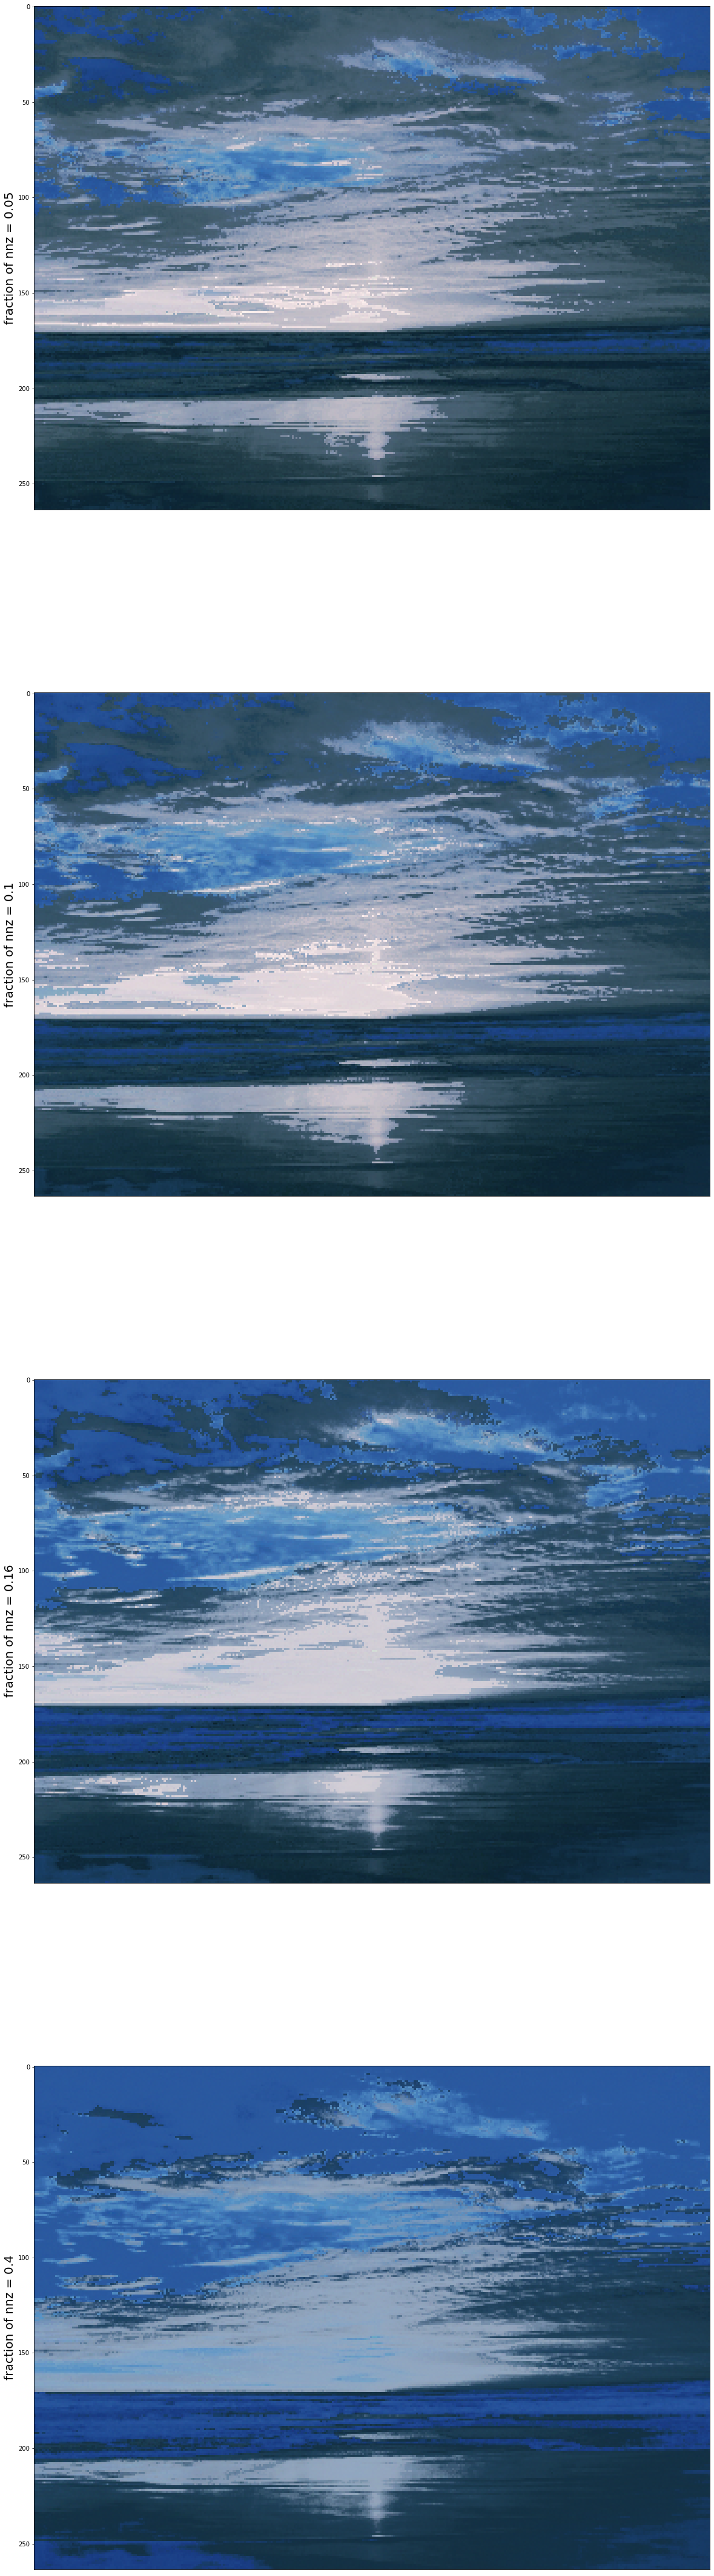

In [57]:
comparator_by_sparsity(I1, I2)

# Tests

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


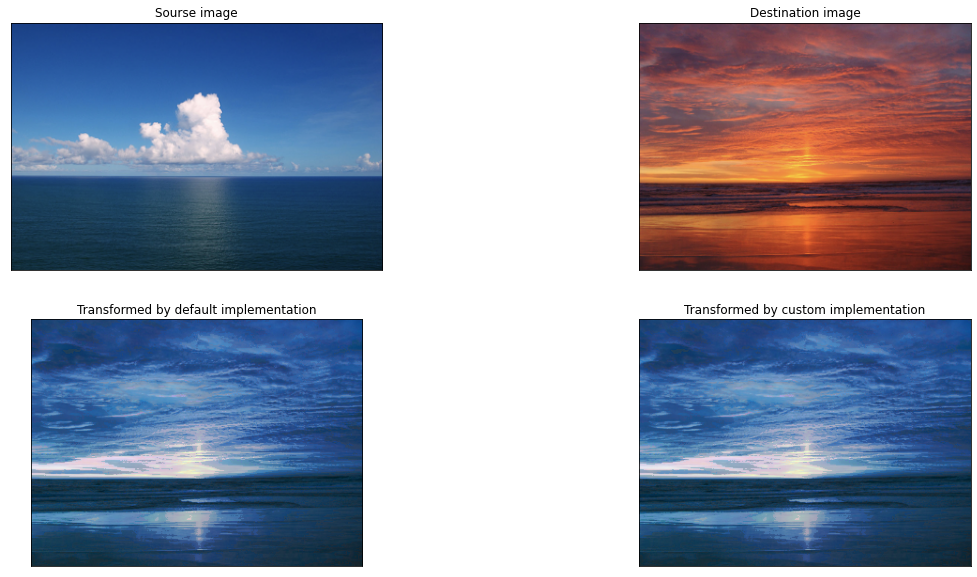

In [19]:
show_transfer_by_different_implementations(I1, I2)

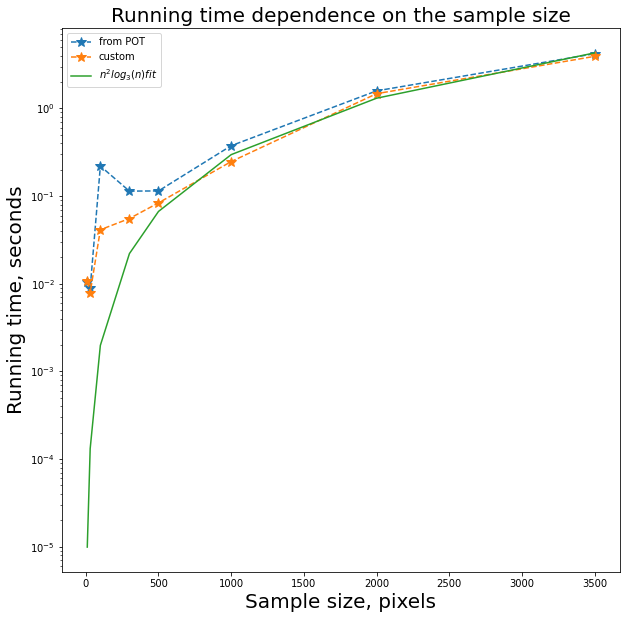

In [74]:
#1
plot_comparator_by_number_of_clusters()

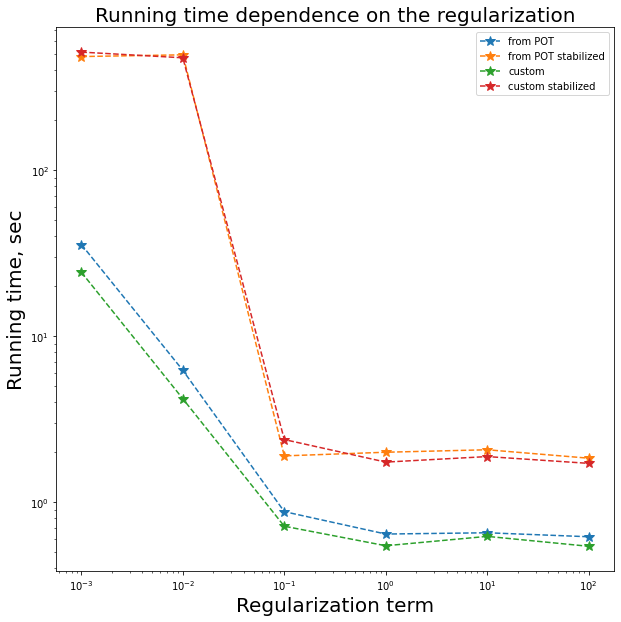

In [97]:
# 2
plot_xxx_by_regularisation_term(xxx="time")

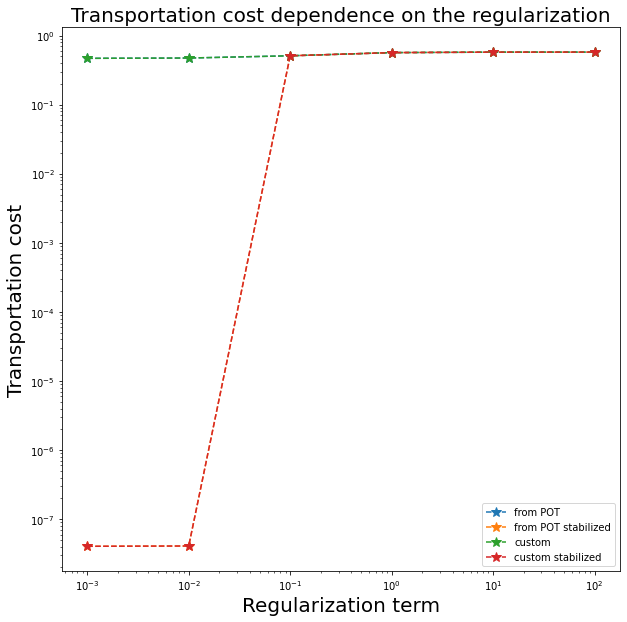

In [41]:
# 3
plot_xxx_by_regularisation_term(xxx="quality")

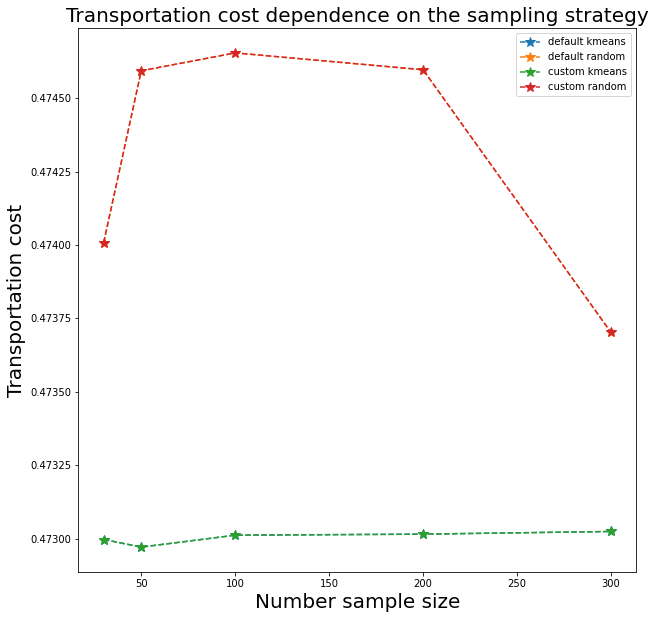

In [42]:
#4
plot_quality_by_sampling()

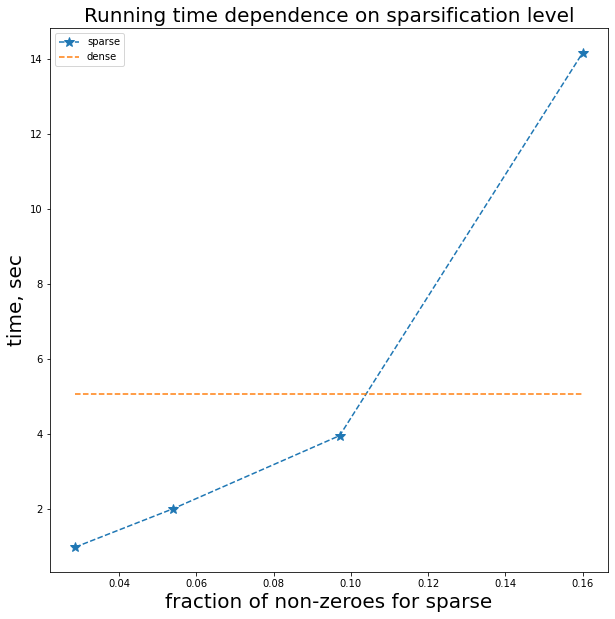

In [45]:
# 5
plot_xxx_by_sparsity(xxx="time")

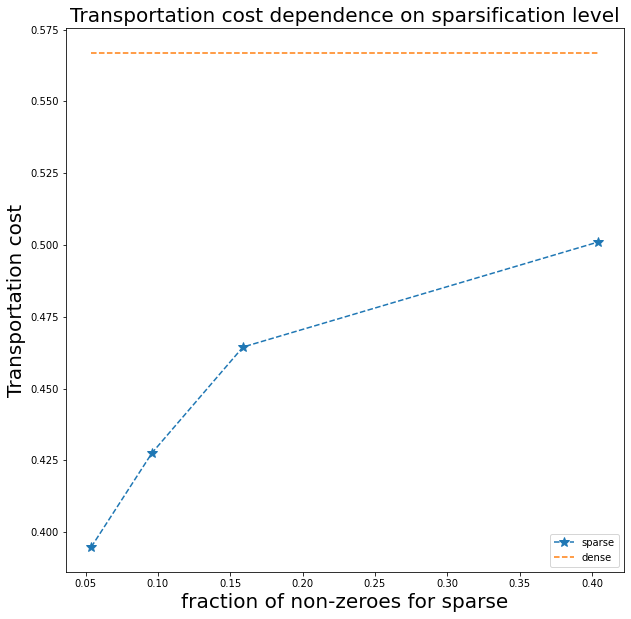

In [46]:
plot_xxx_by_sparsity(xxx="quality")